Loading dataset...
Training set size: 16, Test set size: 4

Evaluating XGBoost...
Performing cross-validation...
Cross-validation MAE: 0.936 ± 0.273
Training model...
Making predictions...
Test MAE: 0.402, RMSE: 0.556, R²: 0.859, Max Error: 1.010
Training Time: 0.132s, Prediction Time: 0.008s
Model saved to xgboost_depth_predictor.joblib

Evaluating Random Forest...
Performing cross-validation...
Cross-validation MAE: 1.166 ± 0.603
Training model...
Making predictions...
Test MAE: 0.374, RMSE: 0.397, R²: 0.928, Max Error: 0.585
Training Time: 0.408s, Prediction Time: 0.035s
Model saved to random_forest_depth_predictor.joblib

Model Validation Summary:
        Model      MAE     RMSE       R2  Max Error  Cross-Val MAE  Cross-Val MAE Std  Training Time (s)  Prediction Time (s)
      XGBoost 0.401624 0.555858 0.858753   1.010287       0.936116           0.272689           0.131710             0.007999
Random Forest 0.373750 0.397453 0.927786   0.585000       1.165750           0.602683   

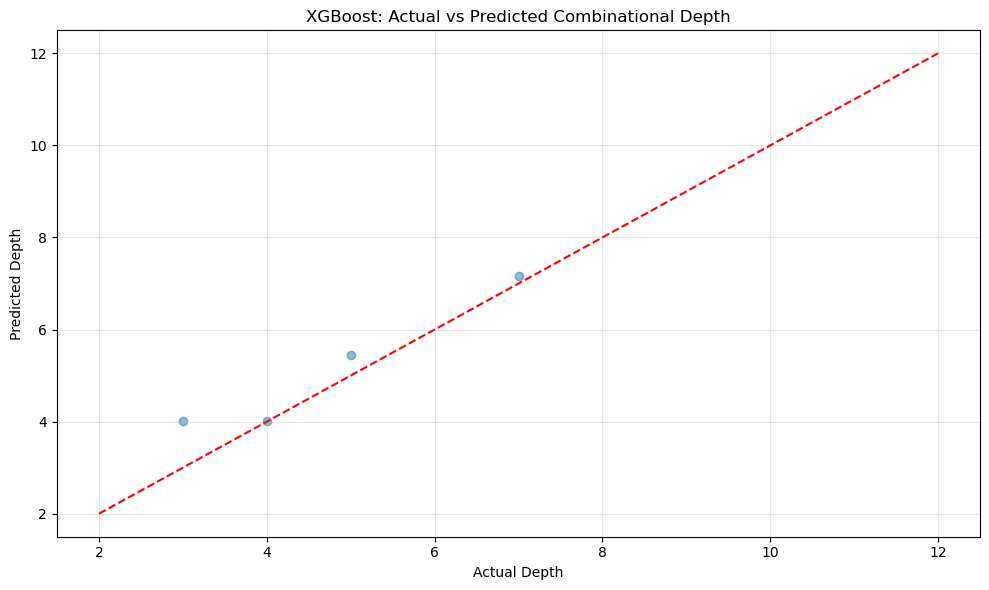

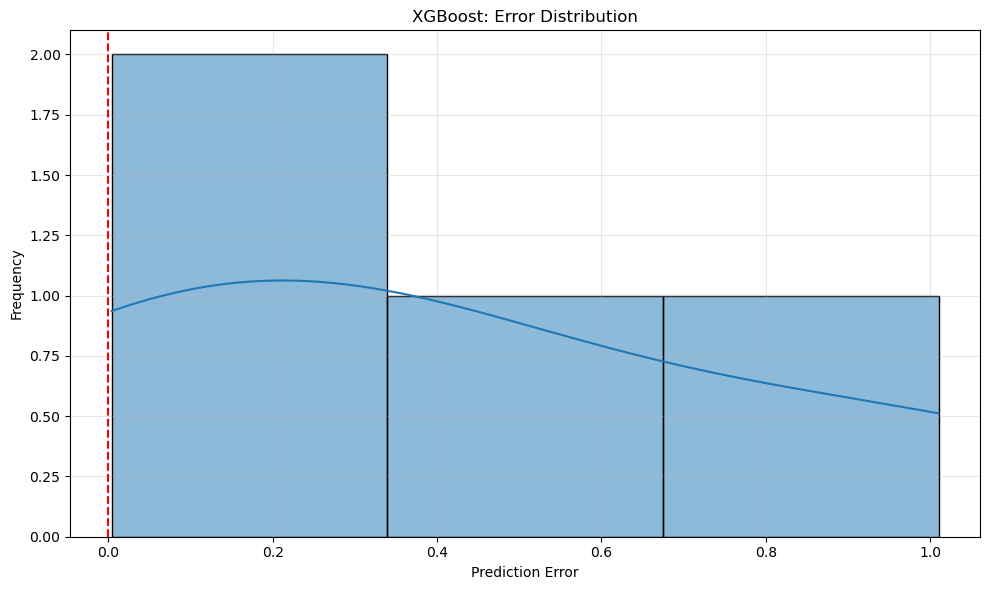

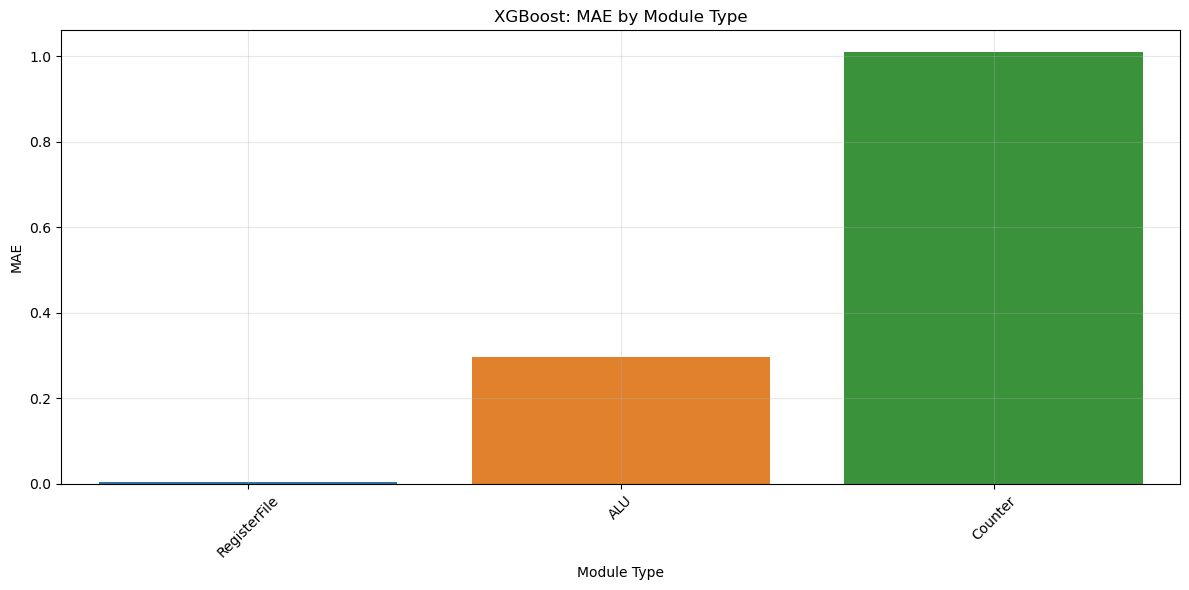

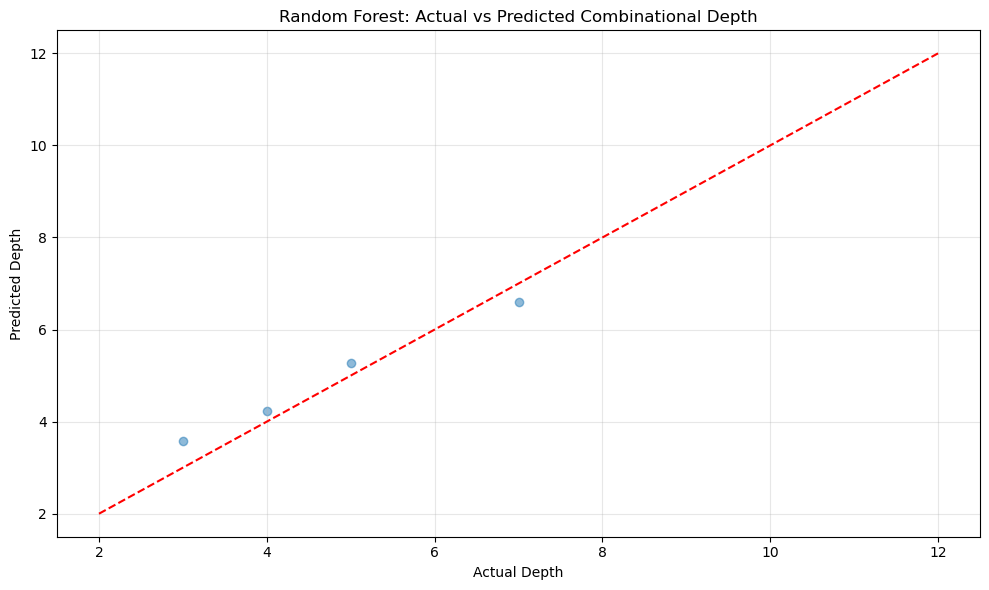

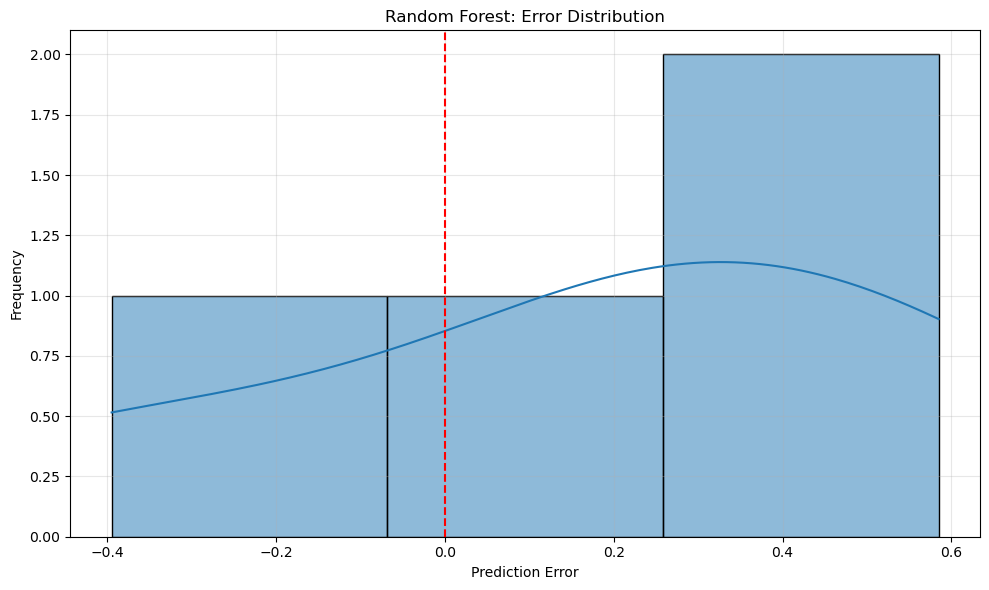

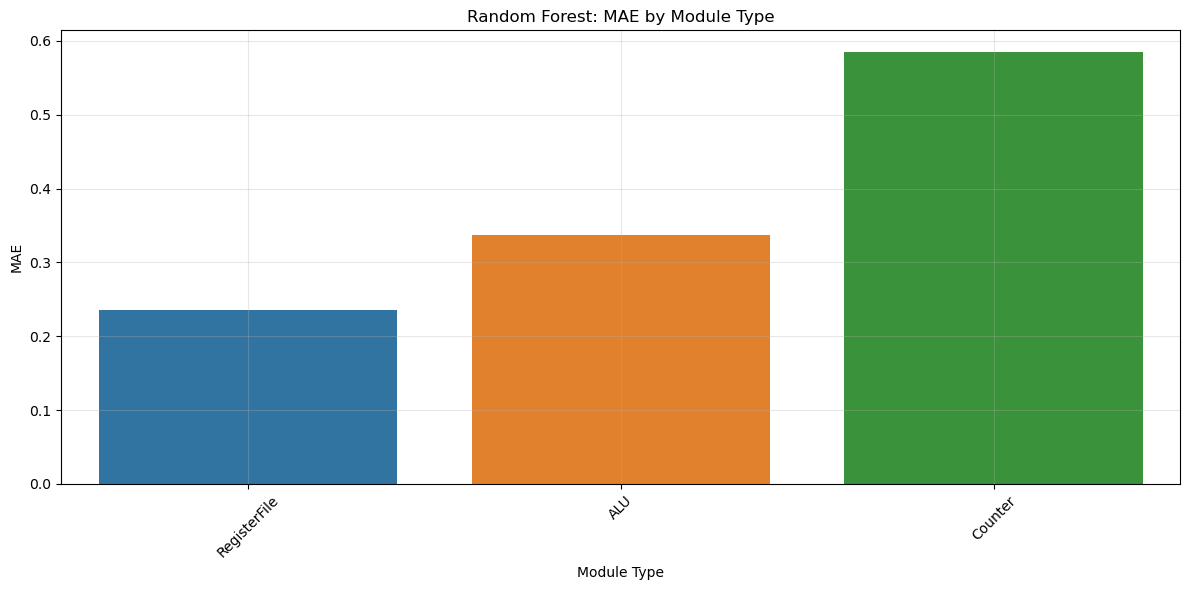

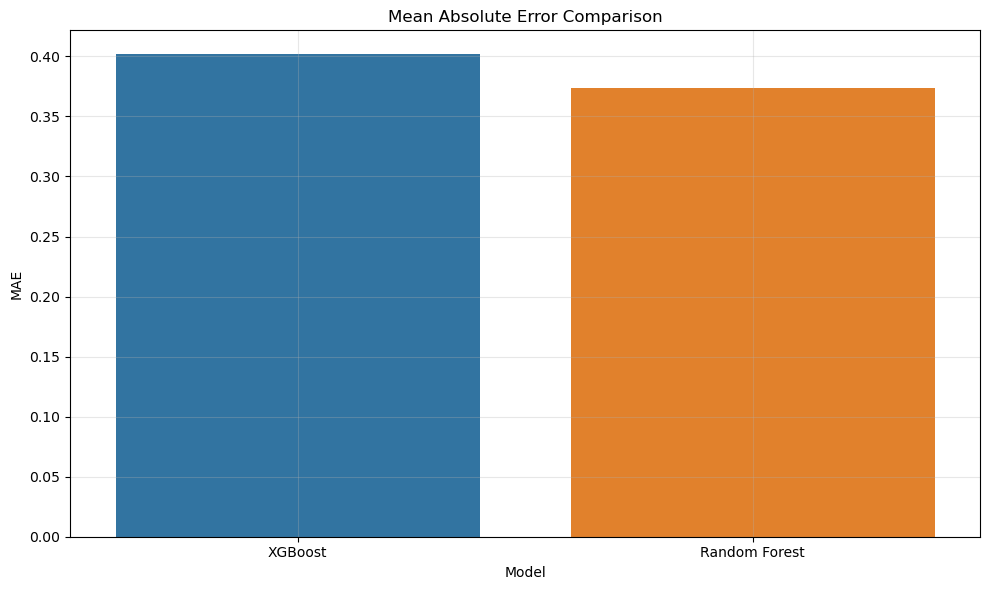

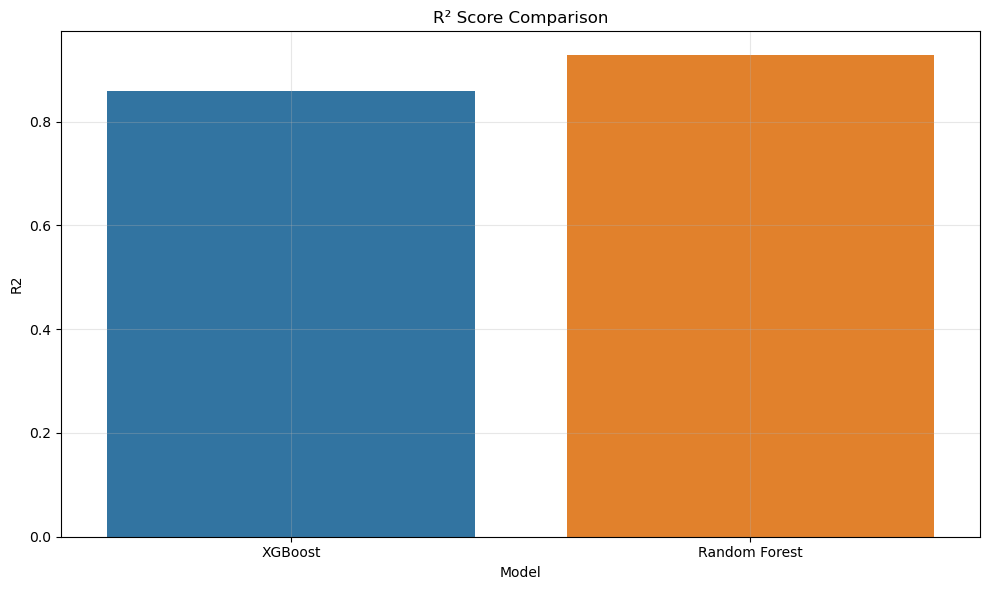

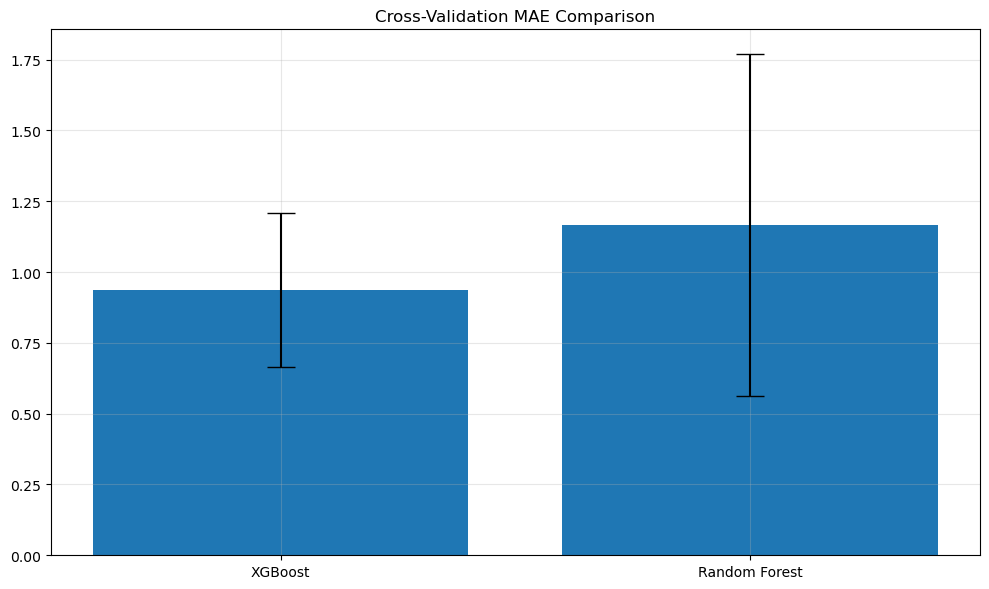

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error
import xgboost as xgb
import time
import joblib

def validate_models(data_path, test_size=0.2, random_state=42, n_folds=5):
    """
    Validate XGBoost vs Random Forest models for RTL depth prediction.
    
    Parameters:
    -----------
    data_path : str
        Path to the dataset CSV
    test_size : float
        Proportion of data to use for testing
    random_state : int
        Random seed for reproducibility
    n_folds : int
        Number of cross-validation folds
    """
    print("Loading dataset...")
    df = pd.read_csv(data_path)
    
    # Split features and target
    X = df.drop(['combinational_depth', 'module_name', 'signal_name'], axis=1, errors='ignore')
    y = df['combinational_depth']
    
    # Define categorical and numerical columns
    categorical_cols = ['module_type']
    numerical_cols = [col for col in X.columns if col not in categorical_cols]
    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ])
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")
    
    # Define models to compare
    models = {
        'XGBoost': xgb.XGBRegressor(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=6,
            min_child_weight=1,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='reg:squarederror',
            random_state=random_state
        ),
        'Random Forest': RandomForestRegressor(
            n_estimators=200,
            max_depth=15,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features='sqrt',
            random_state=random_state
        )
    }
    
    # Results dictionary
    results = {
        'Model': [],
        'MAE': [],
        'RMSE': [],
        'R2': [],
        'Max Error': [],
        'Cross-Val MAE': [],
        'Cross-Val MAE Std': [],
        'Training Time (s)': [],
        'Prediction Time (s)': []
    }
    
    # Define cross-validation strategy
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    # Evaluate each model
    for name, model in models.items():
        print(f"\nEvaluating {name}...")
        
        # Create pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # Cross-validation
        print("Performing cross-validation...")
        cv_scores = cross_val_score(
            pipeline, X_train, y_train, 
            cv=kf, 
            scoring='neg_mean_absolute_error', 
            n_jobs=-1
        )
        cv_mae = -cv_scores.mean()
        cv_mae_std = cv_scores.std()
        
        print(f"Cross-validation MAE: {cv_mae:.3f} ± {cv_mae_std:.3f}")
        
        # Train model
        print("Training model...")
        start_time = time.time()
        pipeline.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        # Make predictions
        print("Making predictions...")
        start_time = time.time()
        y_pred = pipeline.predict(X_test)
        pred_time = time.time() - start_time
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        max_err = max_error(y_test, y_pred)
        
        # Store results
        results['Model'].append(name)
        results['MAE'].append(mae)
        results['RMSE'].append(rmse)
        results['R2'].append(r2)
        results['Max Error'].append(max_err)
        results['Cross-Val MAE'].append(cv_mae)
        results['Cross-Val MAE Std'].append(cv_mae_std)
        results['Training Time (s)'].append(train_time)
        results['Prediction Time (s)'].append(pred_time)
        
        print(f"Test MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}, Max Error: {max_err:.3f}")
        print(f"Training Time: {train_time:.3f}s, Prediction Time: {pred_time:.3f}s")
        
        # Save model
        model_file = f"{name.lower().replace(' ', '_')}_depth_predictor.joblib"
        joblib.dump(pipeline, model_file)
        print(f"Model saved to {model_file}")
        
        # Plot actual vs predicted
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
        plt.xlabel('Actual Depth')
        plt.ylabel('Predicted Depth')
        plt.title(f'{name}: Actual vs Predicted Combinational Depth')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{name.lower().replace(" ", "_")}_actual_vs_predicted.png')
        
        # Plot error distribution
        errors = y_pred - y_test
        plt.figure(figsize=(10, 6))
        sns.histplot(errors, kde=True)
        plt.axvline(x=0, color='r', linestyle='--')
        plt.xlabel('Prediction Error')
        plt.ylabel('Frequency')
        plt.title(f'{name}: Error Distribution')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{name.lower().replace(" ", "_")}_error_distribution.png')
        
        # Analyze performance by module type
        if 'module_type' in X_test.columns:
            module_results = {}
            for module_type in X_test['module_type'].unique():
                module_idx = X_test['module_type'] == module_type
                if sum(module_idx) > 0:  # Ensure there are samples for this module type
                    module_mae = mean_absolute_error(y_test[module_idx], y_pred[module_idx])
                    module_results[module_type] = module_mae
            
            # Plot module-wise MAE
            plt.figure(figsize=(12, 6))
            module_df = pd.DataFrame({
                'Module Type': list(module_results.keys()),
                'MAE': list(module_results.values())
            })
            module_df = module_df.sort_values('MAE')
            
            sns.barplot(x='Module Type', y='MAE', data=module_df)
            plt.title(f'{name}: MAE by Module Type')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(f'{name.lower().replace(" ", "_")}_module_mae.png')
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Save results
    results_df.to_csv('model_validation_results.csv', index=False)
    
    # Comparative visualization
    # MAE comparison
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='MAE', data=results_df)
    plt.title('Mean Absolute Error Comparison')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('model_mae_comparison.png')
    
    # R² comparison
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='R2', data=results_df)
    plt.title('R² Score Comparison')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('model_r2_comparison.png')
    
    # Cross-validation MAE comparison
    plt.figure(figsize=(10, 6))
    plt.bar(
        results_df['Model'], 
        results_df['Cross-Val MAE'], 
        yerr=results_df['Cross-Val MAE Std'],
        capsize=10
    )
    plt.title('Cross-Validation MAE Comparison')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('model_cv_mae_comparison.png')
    
    print("\nModel Validation Summary:")
    print(results_df.to_string(index=False))
    
    # Identify best model
    best_model = results_df.loc[results_df['MAE'].idxmin(), 'Model']
    print(f"\nBest model based on MAE: {best_model}")
    
    return results_df

if __name__ == "__main__":
    results = validate_models('test_dataset2.csv')